In [26]:
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from quantbullet.model_selection import CrossValidationResult, OptunaStudyResult

## Grid Search Example

In [27]:
data = fetch_california_housing()
X, y = data.data, data.target

In [28]:
model = xgb.XGBRegressor(objective ='reg:squarederror')

param_grid = {
    'n_estimators': [30, 50, 70, 90, 110, 200],
    'max_depth': [3, 5, 7, 10, 30, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'alpha': [0.1, 0.5, 1, 2, 5, 10],
    # 'subsample': [0.5, 0.7, 0.9, 1],
    # 'colsample_bytree': [0.5, 0.7, 0.9, 1],
    'min_split_loss': [0, 0.5, 1, 2, 5, 10],
}

In [29]:
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           return_train_score=True,
                           verbose=1,
                           n_jobs=-1)

In [17]:
# grid_search.fit(X, y)
# import pickle
# with open('xgboost_prod.pkl', 'wb') as f:
#     pickle.dump(grid_search, f)

In [30]:
import pickle
with open('xgboost_grid_search_9600.pkl', 'rb') as f:
    grid_search = pickle.load(f)

In [31]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'alpha': 10, 'learning_rate': 0.2, 'max_depth': 5, 'min_split_loss': 0, 'n_estimators': 70}
Best score: -0.38582922255606994


In [32]:
df = CrossValidationResult(grid_search.cv_results_).cv_scores_df()

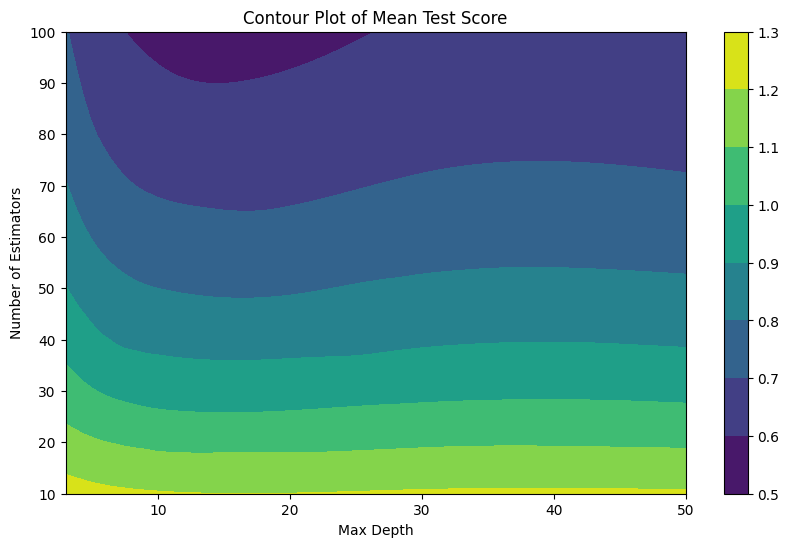

In [33]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# Create grid values
x_grid, y_grid = np.meshgrid(np.linspace(df['max_depth'].min(), df['max_depth'].max(), 100),
                             np.linspace(df['n_estimators'].min(), df['n_estimators'].max(), 100))

# Interpolate z values
z_grid = griddata((df['max_depth'], df['n_estimators']), df['mean_test_score'].abs(), (x_grid, y_grid), method='cubic')

# Contour plot
plt.figure(figsize=(10, 6))
cp = plt.contourf(x_grid, y_grid, z_grid, cmap='viridis')
plt.colorbar(cp)
plt.title('Contour Plot of Mean Test Score')
plt.xlabel('Max Depth')
plt.ylabel('Number of Estimators')
plt.show()


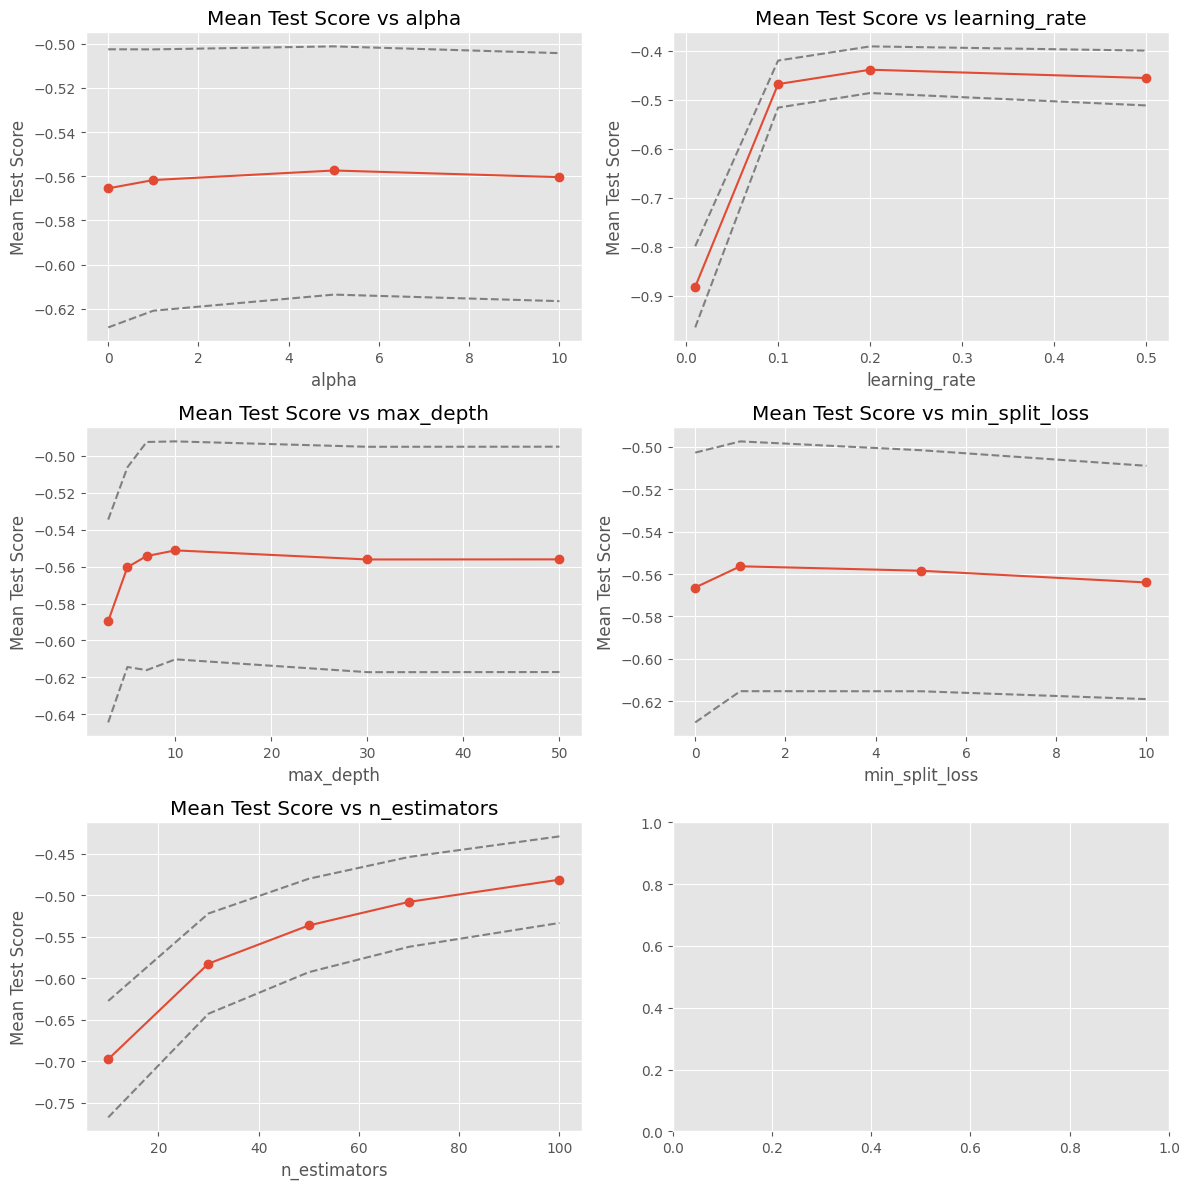

In [34]:
CrossValidationResult(grid_search.cv_results_).partial_cv_scores()

## Optuna

In [35]:
from quantbullet.model_selection import OptunaCVOptimizer, OptunaStudyResult

In [36]:
import xgboost
from sklearn.datasets import fetch_california_housing


data = fetch_california_housing()
X, y = data.data, data.target
optimizer = OptunaCVOptimizer(X, y,
                              xgboost.XGBRegressor(),
                              objective='reg:squarederror',
                              scoring='neg_mean_squared_error', cv=5)

In [37]:
fixed_params = {
    'learning_rate': 0.1,
    'min_split_loss': 0,
    'alpha': 1,
    'subsample': 0.5,
    'colsample_bytree': 1,
    'random_state': 42,
}

tuning_params = {
    'n_estimators': [20, 30, 50, 70, 90, 110, 200],
    'max_depth': [2, 3, 5, 7, 10, 12],
}

In [23]:
optunares = optimizer.optimize(fixed_params, tuning_params, n_trials=100)

Best trial: 40. Best value: -0.37475: 100%|██████████| 100/100 [04:12<00:00,  2.53s/it]


In [20]:
# import optuna
# from sklearn.datasets import fetch_california_housing
# import xgboost as xgb
# from sklearn.model_selection import cross_val_score, learning_curve

# # Fetch the California housing dataset
# data = fetch_california_housing()
# X, y = data.data, data.target


# def objective(trial):
#     # Define the hyperparameter search space
#     params = {
#         "n_estimators": trial.suggest_categorical(
#             "n_estimators", [20, 30, 50, 70, 90, 110, 200]
#         ),
#         "max_depth": trial.suggest_categorical("max_depth", [2, 3, 5, 7, 10, 12]),
#     }

#     # Initialize the XGBoost Regressor with the parameters
#     model = xgb.XGBRegressor(
#         objective="reg:squarederror",
#         learning_rate=0.1,
#         alpha=1,
#         min_split_loss=0,
#         subsample=0.5,
#         colsample_bytree=1,
#         random_state=42,
#         **params,
#     )

#     # Perform cross-validation and return the mean score
#     score = cross_val_score(model, X, y, cv=5, scoring="neg_mean_squared_error").mean()
#     return score


# optuna.logging.set_verbosity(optuna.logging.WARNING)
# # Create a study object and optimize the objective
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100, show_progress_bar=True)

# # Print the result
# best_params = study.best_params
# best_score = study.best_value
# print(f"Best parameters: {best_params}\nBest score: {best_score}")

In [13]:
# import pickle
# with open('xgboost_optuna_study.pkl', 'wb') as f:
#     pickle.dump(study, f)

In [14]:
# import pickle
# with open('xgboost_optuna_study.pkl', 'rb') as f:
#     study = pickle.load(f)

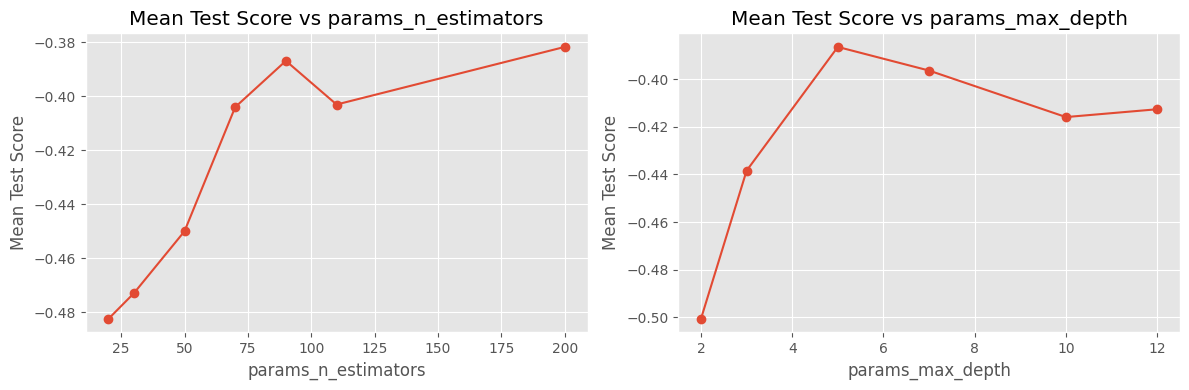

In [38]:
OptunaStudyResult(optunares.study).partial_cv_scores()

## Overfitting Example

In [39]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load the dataset
data = fetch_california_housing()
X, y = data.data, data.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Decision tree regressor
tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, y_train)

# Predictions
train_predictions = tree.predict(X_train)
test_predictions = tree.predict(X_test)

# Calculate MSE
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print(f"Training MSE: {train_mse}")
print(f"Testing MSE: {test_mse}")


Training MSE: 9.904697258622977e-32
Testing MSE: 0.5280096503174904


In [ ]:
# More regularized decision tree
tree_reg = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_reg.fit(X_train, y_train)

# Predictions
train_reg_predictions = tree_reg.predict(X_train)
test_reg_predictions = tree_reg.predict(X_test)

# Calculate MSE
train_reg_mse = mean_squared_error(y_train, train_reg_predictions)
test_reg_mse = mean_squared_error(y_test, test_reg_predictions)

print(f"Regularized Training MSE: {train_reg_mse}")
print(f"Regularized Testing MSE: {test_reg_mse}")

Regularized Training MSE: 0.4928096322147045
Regularized Testing MSE: 0.5210801561811793


In [ ]:
param_grid = {
    'max_depth': [1, 3, 5, 7, 10, 30, 50, 100]
}

grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           return_train_score=True,
                           verbose=1)

In [ ]:
grid_search.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [1, 3, 5, 7, 10, 30, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

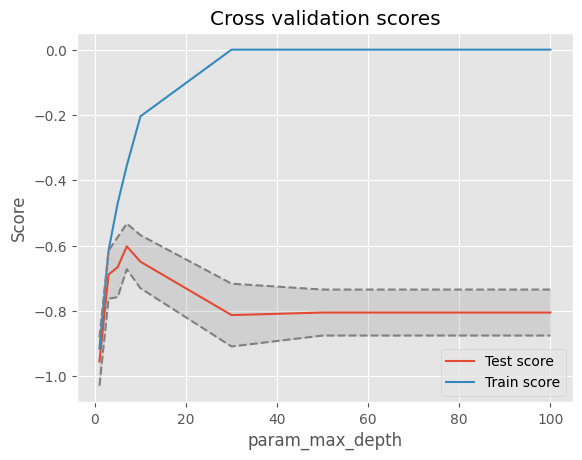

In [ ]:
CrossValidationResult(grid_search.cv_results_).plot_train_test_scores('max_depth')